In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.manifold import TSNE
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from wpca import PCA, WPCA, EMPCA

from TISSUE.tissue.main import *
from TISSUE.tissue.downstream import *
from TISSUE.tissue.experiments import *

from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.stats import ttest_rel
from sklearn.cluster import KMeans

## Simulation/synthetic dataset for testing

In [10]:
def simulate_data (mu, p=1000, sigma_measurement=1, sigma_imputation=1, mixing=0.2):
    '''
    Creates data for simulation of imputation bias between conditions
    '''
    # create ground truth
    truth = np.ones((100,p))*10 # change to mostly positives bc unlike dgea sim, we need to compute PI widths here
    #truth[:50,:] += 10 # half of cells have ground truth expression of 1 for all genes (others zero)
    truth[:50,:round(p/2)] += 10 # upper left quadrant is higher expressed (marker for group 0)
    
    # condition labels
    labels = np.zeros(100)
    labels[50:] = 1
    
    # create spatial coords
    spatial_x = []
    spatial_y = []
    
    for i in range(10):
        for j in range(10):
            spatial_x.append(i)
            spatial_y.append(j)
            
    spatial = np.vstack((spatial_x,spatial_y)).T
    
    # create measurement (Gaussian noise)
    measured = truth + np.random.normal(0,sigma_measurement,truth.shape)
    
    # create imputed
    imputed = np.zeros(measured.shape)
    
    # impute one half consistently with zero-centered Gaussian noise
    imputed[:,round(p/2):] = measured[:,round(p/2):] + np.random.normal(0,sigma_imputation,(imputed.shape[0],round(p/2)))
    
    # impute other half with bias of mu offset for one group
    n_mix = round(mixing*100/2)
    random_idxs = np.random.choice(np.arange(50,100),n_mix,replace=False)
    imputed[random_idxs,:round(p/2)] = measured[random_idxs,:round(p/2)] + np.random.normal(mu,sigma_imputation,
                                                                        (n_mix,imputed.shape[1]-round(p/2)))
    imputed[[i for i in range(100) if i not in random_idxs],:round(p/2)] = measured[[i for i in range(100) if i not in random_idxs],:round(p/2)] + np.random.normal(0,sigma_imputation,
                                                                        (100-n_mix,imputed.shape[1]-round(p/2)))
    
    # create adata
    adata = ad.AnnData(measured)
    adata.obsm["sim_predicted_expression"] = pd.DataFrame(imputed, columns=adata.var_names, index=adata.obs_names)
    adata.obsm["spatial"] = spatial
    adata.obs["condition"] = labels.astype(int).astype(str)
    
    # get calib genes (50%)
    calib_genes=adata.var_names[round(p/4):round(3/4*p)]
    
    return (adata, calib_genes, labels)

In [11]:
adata, calib_genes, labels = simulate_data(mu=10, p=1000, mixing=0.5)

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)


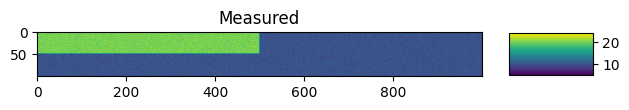

In [12]:
plt.title("Measured")
im = plt.imshow(adata.X)
plt.colorbar(im,aspect=0.5) #fraction=0.046*im_ratio, pad=0.04,
plt.tight_layout()
#plt.savefig(f"plots/scpi_clustering/simulated_measured_matrix.pdf", bbox_inches="tight")
plt.show()

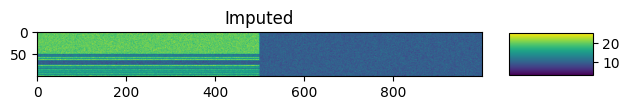

In [13]:
plt.title("Imputed")
im = plt.imshow(adata.obsm['sim_predicted_expression'])
plt.colorbar(im,aspect=0.5) #fraction=0.046*im_ratio, pad=0.04,
plt.tight_layout()
#plt.savefig(f"plots/scpi_clustering/simulated_imputed_matrix.pdf", bbox_inches="tight")
plt.show()

In [14]:
# build spatial graph
build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
calc_adjacency_weights(adata, method="cosine")

# conformalize
conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                 grouping_method="kmeans_gene_cell", k=2, k2=2, n_pc=15)

In [15]:
# get PI's
conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.33)

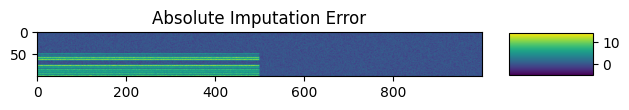

In [16]:
plt.title("Absolute Imputation Error")
im = plt.imshow(adata.obsm['sim_predicted_expression'].values-adata.X)
plt.colorbar(im,aspect=0.5) #fraction=0.046*im_ratio, pad=0.04,
plt.tight_layout()
#plt.savefig(f"plots/scpi_clustering/simulated_imputationerror_matrix.pdf", bbox_inches="tight")
plt.show()

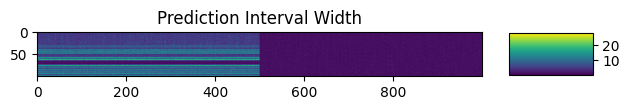

In [17]:
plt.title("Prediction Interval Width")
im = plt.imshow(adata.obsm['sim_predicted_expression_hi'].values-adata.obsm['sim_predicted_expression_lo'].values)
plt.colorbar(im,aspect=0.5) #fraction=0.046*im_ratio, pad=0.04,
plt.tight_layout()
#plt.savefig(f"plots/scpi_clustering/simulated_piwidth67_matrix.pdf", bbox_inches="tight")
plt.show()

In [28]:
from skimage.filters import threshold_otsu

threshold_otsu(1/(adata.obsm['sim_predicted_expression_hi'].values-adata.obsm['sim_predicted_expression_lo'].values))

0.36407983563859436

### Separability and ARI as function of mixing proportion

In [18]:
from sklearn.svm import SVC

n_components=15

mix_props = np.linspace(0,1,20)


mix_dict = {}
for key in ["measured", "imputed", "piwidth", "residual"]:
    mix_dict[key] = {}
    mix_dict[key]["mean_svm_linear_acc"] = []
    mix_dict[key]["range_svm_linear_acc"] = []
    mix_dict[key]["mean_ARI"] = []
    mix_dict[key]["range_ARI"] = []


for mix in mix_props:
    
    measured_acc = []
    imputed_acc = []
    imputed_weighted_piwidth_acc = []
    imputed_weighted_residual_acc = []
    
    measured_ari = []
    imputed_ari = []
    imputed_weighted_piwidth_ari = []
    imputed_weighted_residual_ari = []
    
    for i in range(20):
    
        adata, calib_genes, labels = simulate_data(mu=10, p=1000, mixing=mix)
        true_clusters = labels

        # build spatial graph
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
        calc_adjacency_weights(adata, method="cosine")

        # conformalize
        conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                         grouping_method="kmeans_gene_cell", k=2, k2=2, n_pc=15)

        # get PI's
        conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.23)

        # run PCA
        X_red = StandardScaler().fit_transform(adata.X)
        X_red = WPCA(n_components=n_components).fit_transform(X_red)
        
        # Unweighted
        weighted_PCA(adata, "sim", pca_method="wpca", weighting="uniform",
                     n_components=n_components, tag="unweighted", scale=True)
        X_red_imp = adata.obsm['sim_predicted_expression_PC15_unweighted']
        
        # Weighted
        w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_norm_pi_width",
                         binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
                         n_components=n_components, tag="weighted", replace_inf="max", scale=True, return_weights=True)
        X_red_imp_weighted = adata.obsm['sim_predicted_expression_PC15_weighted']
        
        # Weighted-Residual
        w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_residual",
                         binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
                         n_components=n_components, tag="weighted_res", replace_inf="max", scale=True, return_weights=True)
        X_red_imp_weighted_res = adata.obsm['sim_predicted_expression_PC15_weighted_res']

        # Linear separability with SVC
        clf = SVC(kernel='linear', random_state=444).fit(X_red, true_clusters)
        measured_acc.append(clf.score(X_red, true_clusters))

        clf = SVC(kernel='linear', random_state=444).fit(X_red_imp, true_clusters)
        imputed_acc.append(clf.score(X_red_imp, true_clusters))

        clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_weighted, true_clusters)
        imputed_weighted_piwidth_acc.append(clf.score(X_red_imp_weighted, true_clusters))
        
        clf = SVC(kernel='linear', random_state=444).fit(X_red_imp_weighted_res, true_clusters)
        imputed_weighted_residual_acc.append(clf.score(X_red_imp_weighted_res, true_clusters))
        
        # Clustering + Adjusted Rand Index
        kmeans = KMeans(n_clusters=2).fit(X_red)
        clusters = kmeans.labels_
        measured_ari.append(adjusted_rand_score(true_clusters, clusters))

        kmeans = KMeans(n_clusters=2).fit(X_red_imp)
        clusters = kmeans.labels_
        imputed_ari.append(adjusted_rand_score(true_clusters, clusters))
        
        kmeans = KMeans(n_clusters=2).fit(X_red_imp_weighted)
        clusters = kmeans.labels_
        imputed_weighted_piwidth_ari.append(adjusted_rand_score(true_clusters, clusters))
        
        kmeans = KMeans(n_clusters=2).fit(X_red_imp_weighted_res)
        clusters = kmeans.labels_
        imputed_weighted_residual_ari.append(adjusted_rand_score(true_clusters, clusters))
        
        
    # append results
    mix_dict["measured"]["mean_svm_linear_acc"].append(np.nanmean(measured_acc))
    mix_dict["imputed"]["mean_svm_linear_acc"].append(np.nanmean(imputed_acc))
    mix_dict["piwidth"]["mean_svm_linear_acc"].append(np.nanmean(imputed_weighted_piwidth_acc))
    mix_dict["residual"]["mean_svm_linear_acc"].append(np.nanmean(imputed_weighted_residual_acc))
    
    mix_dict["measured"]["range_svm_linear_acc"].append((np.nanquantile(measured_acc,0.25),(np.nanquantile(measured_acc,0.75))))
    mix_dict["imputed"]["range_svm_linear_acc"].append((np.nanquantile(imputed_acc,0.25),(np.nanquantile(imputed_acc,0.75))))
    mix_dict["piwidth"]["range_svm_linear_acc"].append((np.nanquantile(imputed_weighted_piwidth_acc,0.25),(np.nanquantile(imputed_weighted_piwidth_acc,0.75))))
    mix_dict["residual"]["range_svm_linear_acc"].append((np.nanquantile(imputed_weighted_residual_acc,0.25),(np.nanquantile(imputed_weighted_residual_acc,0.75))))
    
    # append results
    mix_dict["measured"]["mean_ARI"].append(np.nanmean(measured_ari))
    mix_dict["imputed"]["mean_ARI"].append(np.nanmean(imputed_ari))
    mix_dict["piwidth"]["mean_ARI"].append(np.nanmean(imputed_weighted_piwidth_ari))
    mix_dict["residual"]["mean_ARI"].append(np.nanmean(imputed_weighted_residual_ari))
    
    mix_dict["measured"]["range_ARI"].append((np.nanquantile(measured_ari,0.25),(np.nanquantile(measured_ari,0.75))))
    mix_dict["imputed"]["range_ARI"].append((np.nanquantile(imputed_ari,0.25),(np.nanquantile(imputed_ari,0.75))))
    mix_dict["piwidth"]["range_ARI"].append((np.nanquantile(imputed_weighted_piwidth_ari,0.25),(np.nanquantile(imputed_weighted_piwidth_ari,0.75))))
    mix_dict["residual"]["range_ARI"].append((np.nanquantile(imputed_weighted_residual_ari,0.25),(np.nanquantile(imputed_weighted_residual_ari,0.75))))

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

In [19]:
# pickle dict
with open(f"results/clustering/simulated_mix_0_1_20_default_params_20rep_FINAL_bin020_invnorm.pkl", "wb") as f:
    pickle.dump(mix_dict, f)

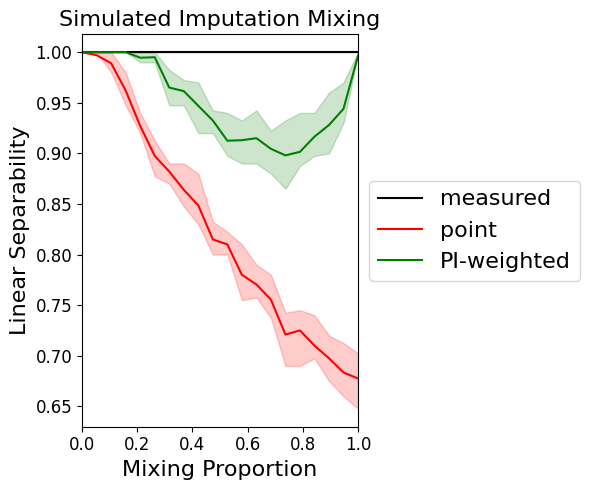

In [23]:
filename = "simulated_mix_0_1_20_default_params_20rep_FINAL_bin020_invnorm"
mix_props = np.linspace(0,1,20)
start = 0

########################################
with open(f"results/clustering/{filename}.pkl", "rb") as f:
    mix_dict = pickle.load(f)

plt.figure(figsize=(6,5))

plt.plot(mix_props[start:], mix_dict["measured"]["mean_svm_linear_acc"][start:], label="measured", color="k")
plt.plot(mix_props[start:], mix_dict["imputed"]["mean_svm_linear_acc"][start:], label="point", color="r")
plt.plot(mix_props[start:], mix_dict["piwidth"]["mean_svm_linear_acc"][start:], label="PI-weighted", color="g")
#plt.plot(mix_props[start:], mix_dict["residual"]["mean_svm_linear_acc"][start:], label="error-weighted", color="b")

plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["measured"]["range_svm_linear_acc"]][start:],
                 [x[1] for x in mix_dict["measured"]["range_svm_linear_acc"]][start:], color="k", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["imputed"]["range_svm_linear_acc"]][start:],
                 [x[1] for x in mix_dict["imputed"]["range_svm_linear_acc"]][start:], color="r", alpha=0.2)
plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["piwidth"]["range_svm_linear_acc"]][start:],
                 [x[1] for x in mix_dict["piwidth"]["range_svm_linear_acc"]][start:], color="g", alpha=0.2)
#plt.fill_between(mix_props[start:], [x[0] for x in mix_dict["residual"]["range_svm_linear_acc"]][start:],
#                 [x[1] for x in mix_dict["residual"]["range_svm_linear_acc"]][start:], color="b", alpha=0.2)

plt.title("Simulated Imputation Mixing", fontsize=16)
plt.xlabel(r"Mixing Proportion", fontsize=16)
plt.ylabel("Linear Separability", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
plt.xlim(np.min(mix_props[start:]),np.max(mix_props[start:]))
plt.tight_layout()
plt.savefig(f"plots/scpi_clustering/{filename}_linear_separability_bin020.pdf", bbox_inches="tight")
plt.show()

#### Generate multiple PC visualizations for DynamicViz

In [20]:
mix = 1.0
n_components=15
n_runs = 20

results_dict = {}
for key in ["measured", "imputed", "imputed-weighted"]:
    results_dict[key] = {}
    results_dict[key]['x1'] = []
    results_dict[key]['x2'] = []
    results_dict[key]['original_index'] = []
    results_dict[key]['bootstrap_number'] = []
    results_dict[key]['label'] = []


#####################################
for i in range(n_runs):
    adata, calib_genes, labels = simulate_data(mu=10, p=1000, mixing=mix)
    true_clusters = labels

    # build spatial graph
    build_spatial_graph(adata, method="fixed_radius", n_neighbors=15)
    calc_adjacency_weights(adata, method="cosine")

    # conformalize
    conformalize_spatial_uncertainty(adata, "sim_predicted_expression", calib_genes, weight="exp_cos", mean_normalized=False,
                                     grouping_method="kmeans_gene_cell", k=2, k2=2, n_pc=15)

    # get PI's
    conformalize_prediction_interval(adata, "sim_predicted_expression", calib_genes, alpha_level=0.23)

    # run PCA
    X_red = StandardScaler().fit_transform(adata.X)
    X_red = WPCA(n_components=n_components).fit_transform(X_red)

    weighted_PCA(adata, "sim", pca_method="wpca", weighting="uniform",
                 n_components=n_components, tag="unweighted", scale=True)
    X_red_imp = adata.obsm['sim_predicted_expression_PC15_unweighted']

    w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_norm_pi_width",
                     binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
                     n_components=n_components, tag="weighted", replace_inf="max", scale=True, return_weights=True)
    X_red_imp_weighted = adata.obsm['sim_predicted_expression_PC15_weighted']

    w = weighted_PCA(adata, "sim", pca_method="wpca", weighting="inverse_residual",
                     binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
                     n_components=n_components, tag="weighted_res", replace_inf="max", scale=True, return_weights=True)
    X_red_imp_weighted_res = adata.obsm['sim_predicted_expression_PC15_weighted_res']
    
    # append results
    results_dict["measured"]['x1'].append(X_red[:,0])
    results_dict["measured"]['x2'].append(X_red[:,1])
    results_dict["measured"]['original_index'].append(np.arange(X_red.shape[0]))
    results_dict["measured"]['bootstrap_number'].append(np.ones(X_red.shape[0])*i)
    results_dict["measured"]['label'].append(true_clusters)
    
    results_dict["imputed"]['x1'].append(X_red_imp[:,0])
    results_dict["imputed"]['x2'].append(X_red_imp[:,1])
    results_dict["imputed"]['original_index'].append(np.arange(X_red_imp.shape[0]))
    results_dict["imputed"]['bootstrap_number'].append(np.ones(X_red_imp.shape[0])*i)
    results_dict["imputed"]['label'].append(true_clusters)
    
    results_dict["imputed-weighted"]['x1'].append(X_red_imp_weighted[:,0])
    results_dict["imputed-weighted"]['x2'].append(X_red_imp_weighted[:,1])
    results_dict["imputed-weighted"]['original_index'].append(np.arange(X_red_imp_weighted.shape[0]))
    results_dict["imputed-weighted"]['bootstrap_number'].append(np.ones(X_red_imp_weighted.shape[0])*i)
    results_dict["imputed-weighted"]['label'].append(true_clusters)
    
for key in ["measured", "imputed", "imputed-weighted"]:
    results_dict[key]['x1'] = np.concatenate(results_dict[key]['x1'])
    results_dict[key]['x2'] = np.concatenate(results_dict[key]['x2'])
    results_dict[key]['original_index'] = np.concatenate(results_dict[key]['original_index'])
    results_dict[key]['bootstrap_number'] = np.concatenate( results_dict[key]['bootstrap_number'])
    results_dict[key]['label'] = np.concatenate(results_dict[key]['label'])

/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(measured)
/tmp/ipykernel_87/3888049973.py:63: FutureWarning: X

In [21]:
# pickle dict
with open(f"results/clustering/dynamicviz_simulated_mix_100_default_params_20rep_bin020_invnorm.pkl", "wb") as f:
    pickle.dump(results_dict, f)

# Clustering comparison on all imputed genes (Rand index w.r.t. ground truth clustering on the measured genes

#### Combining multiple k_gene and k_cell setups

In [6]:
#dirnames = ["2023Feb17_k4", "2023Feb17_k4k2", "2023Feb17_k3k3"]
dirnames = ["2023Feb20_k4k1_SDbasedCCplus1", "2023Mar4_k4k2_SDbasedCCplus1", "2023Mar4_k3k3_SDbasedCCplus1"]
dataset_names = ["Dataset3", "Dataset9", "Dataset11", "Dataset12", "Dataset13", "Dataset14", "Dataset15", "Dataset17"]
methods = ['knn', 'spage', 'tangram']
n_components = 15


######################################


df_dict = {}
df_dict["Dataset"] = []
df_dict["Imputation Method"] = []
df_dict["PCA"] = []
df_dict["Adjusted Rand Index"] = []
df_dict["Silhouette Score"] = []
df_dict["Directory"] = []


# additional stats
n_clusters_measured = []
n_clusters_unweighted = []
n_clusters_weighted = []


for dirname in dirnames:
    for d in dataset_names:

        adata = sc.read_h5ad(f'scg_results/scpi/{dirname}/{d}_knn_spage_tangram_SCPI.h5ad')

        ### PCA ###

        # Get ground truth PCA
        X_red = StandardScaler().fit_transform(adata.X)
        X_red = WPCA(n_components=n_components).fit_transform(X_red)

        # Get ground truth clustering
        true_clusters, X_pca_true = leiden_clustering(adata, pca=True)
        n_clusters_measured.append(len(np.unique(true_clusters)))

        # Get imputation PCA + clustering and compute quality metrics
        for m in methods:
            #try:
            adata.obsm[f'{m}_predicted_expression_hi'] = adata.obsm[f'{m}_predicted_expression_hi_67']
            adata.obsm[f'{m}_predicted_expression_lo'] = adata.obsm[f'{m}_predicted_expression_lo_67']

            # PCA using only imputation (unweighted)
            weighted_PCA(adata, m, pca_method="wpca", weighting="uniform",
                         n_components=n_components, tag="unweighted", scale=True)

            # PCA using uncertainties (weighted)
            w = weighted_PCA(adata, m, pca_method="wpca", weighting="inverse_norm_pi_width",
                             binarize=0.2, binarize_ratio=10, quantile_cutoff=None, log_transform=False,
                             n_components=n_components, tag="weighted", replace_inf="max", scale=True, return_weights=True)
        
            # Clustering using only imputation (unweighted)
            adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
            imp_clusters, X_pca_imp = leiden_clustering(adata_imp, pca=False)
            n_clusters_unweighted.append(len(np.unique(imp_clusters)))

            # Clustering using uncertainties (weighted)
            adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
            imp_clusters_weighted, X_pca_imp_weighted = leiden_clustering(adata_imp, pca=False)
            n_clusters_weighted.append(len(np.unique(imp_clusters_weighted)))

            # Compare to original and compute rand index
            unweighted_ri = adjusted_rand_score(true_clusters, imp_clusters)
            weighted_ri = adjusted_rand_score(true_clusters, imp_clusters_weighted)
            unweighted_ss = silhouette_score(X_pca_imp, imp_clusters)
            weighted_ss = silhouette_score(X_pca_imp_weighted, imp_clusters_weighted)

            # Append results to dictionary
            df_dict["Dataset"] += [d,d]
            df_dict["Directory"] += [dirname, dirname]
            df_dict["Imputation Method"] += [m,m]
            df_dict["PCA"] += ["unweighted", "weighted"]
            df_dict["Adjusted Rand Index"] += [unweighted_ri, weighted_ri]
            df_dict["Silhouette Score"] += [unweighted_ss, weighted_ss]
#             except:
#                 continue # will just skip these values in results to to failure to converge PCA

/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, 

/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, 

/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, 

/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, 

/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, 

/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
/home/edsun/anaconda3/envs/geneimputation/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
/tmp/ipykernel_87/2932584028.p

/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_unweighted"])
/tmp/ipykernel_87/2932584028.py:65: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_imp = ad.AnnData(X = adata.obsm[f"{m}_predicted_expression_PC{n_components}_weighted"])
/tmp/ipykernel_87/2932584028.py:60: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, 

In [7]:
print("Median number of clusters by approach:")
print(np.median(n_clusters_measured))
print(np.median(n_clusters_unweighted))
print(np.median(n_clusters_weighted))

Median number of clusters by approach:
11.0
19.5
17.0


In [8]:
df = pd.DataFrame(df_dict)
df["Dataset"] = [x.split("Dataset")[1] for x in df["Dataset"].values]

### Adjusted Rand Index

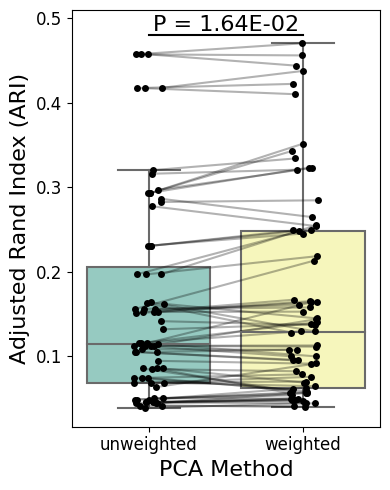

In [9]:
fig, ax = plt.subplots(figsize=(4,5))

sns.stripplot(data=df, x="PCA", y="Adjusted Rand Index", c='k')
sns.boxplot(data=df, x="PCA", y="Adjusted Rand Index", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [0.48]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(df[df["PCA"]=="unweighted"]["Adjusted Rand Index"], df[df["PCA"]=="weighted"]["Adjusted Rand Index"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
    
plt.ylim(None, y+0.03)
    
plt.xlabel("PCA Method", fontsize=16)
plt.ylabel("Adjusted Rand Index (ARI)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
#plt.savefig(f"plots/scpi_clustering/full_imputation_clustering_ARI_ALL_combined_SDcc_020binarized.pdf", bbox_inches="tight")
plt.show()

In [8]:
from scipy.stats import ttest_rel
print(df[df["PCA"]=="unweighted"]["Adjusted Rand Index"].mean()-df[df["PCA"]=="weighted"]["Adjusted Rand Index"].mean())
ttest_rel(df[df["PCA"]=="unweighted"]["Adjusted Rand Index"], df[df["PCA"]=="weighted"]["Adjusted Rand Index"])

-0.005911289587768903


Ttest_relResult(statistic=-2.4586281175041442, pvalue=0.016387348374646723)

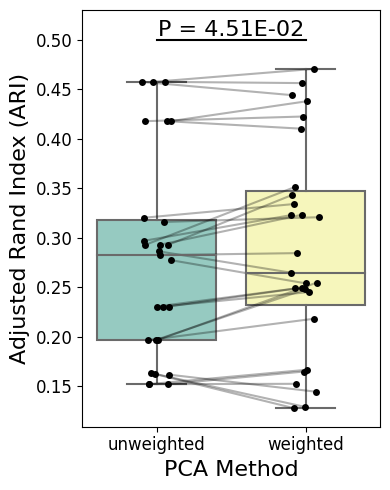

In [9]:
sub_df = df[df["Dataset"].isin(["9","14","17"])]

fig, ax = plt.subplots(figsize=(4,5))

sns.stripplot(data=sub_df, x="PCA", y="Adjusted Rand Index", c='k')
sns.boxplot(data=sub_df, x="PCA", y="Adjusted Rand Index", palette="Set3", showfliers=False)

# Draw connecting lines
locs1 = ax.get_children()[0].get_offsets()
locs2 = ax.get_children()[1].get_offsets()
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.3)
    
# statistical annotation
x_coords = [0.5]
y_coords = [0.5]
cols = ['k']
h = 0
w = 0.5
t,p = ttest_rel(sub_df[sub_df["PCA"]=="unweighted"]["Adjusted Rand Index"], sub_df[sub_df["PCA"]=="weighted"]["Adjusted Rand Index"])
pval_labels = [p]
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)

plt.ylim(None, y+0.03)
    
plt.xlabel("PCA Method", fontsize=16)
plt.ylabel("Adjusted Rand Index (ARI)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(f"plots/scpi_clustering/full_imputation_clustering_ARI_9_14_17_SDcc_020binarized.pdf", bbox_inches="tight")
plt.show()

In [10]:
from scipy.stats import ttest_rel
print(sub_df[sub_df["PCA"]=="unweighted"]["Adjusted Rand Index"].mean()-sub_df[sub_df["PCA"]=="weighted"]["Adjusted Rand Index"].mean())
ttest_rel(sub_df[sub_df["PCA"]=="unweighted"]["Adjusted Rand Index"], sub_df[sub_df["PCA"]=="weighted"]["Adjusted Rand Index"])

-0.010390575285632309


Ttest_relResult(statistic=-2.1051301028144747, pvalue=0.04509464542546291)